In [1]:
%load_ext autoreload
%autoreload 2

The following cell plots the average time taken to validate a 
candidate password. You can see how better candidates
take more time to validate:

0000000000 - 588.5
5000000000 - 634.0
5500000000 - 696.0
5550000000 - 779.0
5555000000 - 856.0
5555500000 - 925.5
5555550000 - 1008.0
5555555000 - 1078.5
5555555500 - 1328.0
5555555550 - 1176.0
5555555555 - 1172.5


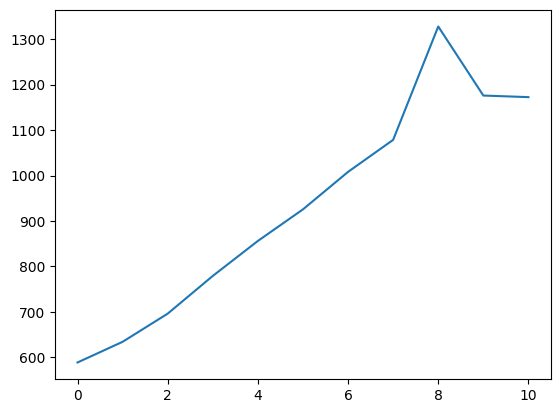

In [48]:
import time

from matplotlib import pyplot as plt

from auth import validate

import statistics

candidates = [
    "0000000000",
    "5000000000",
    "5500000000",
    "5550000000",
    "5555000000",
    "5555500000",
    "5555550000",
    "5555555000",
    "5555555500",
    "5555555550",
    "5555555555",
]

nanoseconds = [0 for _ in range(len(candidates))]

for i, candidate in enumerate(candidates):
    iterations = 10
    results = []
    for j in range(iterations):
        start = time.time_ns()
        validate(candidate)
        end = time.time_ns()
        results.append(end - start)
    nanoseconds[i] = statistics.median(results)
    print(f"{candidate} - {nanoseconds[i]}")

plt.plot(nanoseconds)

The following cell runs a Brute Force Algorithm to try all possible passwords against the weak password
validation function:

In [45]:
from bf import main

args = {
    "NUMBER_ITERATIONS": 0,
    "BRAKE_ON_SOLUTION": True,
}

%time main(args=args)

Solution = 5555555555
CPU times: user 56min 42s, sys: 9.26 ms, total: 56min 42s
Wall time: 56min 43s


The following cell runs a Genetic Algorithm to 
execute a timing attack on the weak password 
validation function:

Initial Population

Member 8948321691 Fitness 538.5
Member 8237827375 Fitness 558.5
Member 2768100420 Fitness 538.0
Member 3991755843 Fitness 536.5
Member 3911261414 Fitness 537.0
Member 9456364432 Fitness 524.0
Member 4877917568 Fitness 512.5
Member 8266818657 Fitness 519.5
Member 0849086428 Fitness 526.0
Member 5859224552 Fitness 538.0
Member 1042714804 Fitness 479.0
Member 9358443185 Fitness 617.0
Member 9832307085 Fitness 456.0
Member 6894439659 Fitness 457.5
Member 2805364484 Fitness 458.5
Member 6180415937 Fitness 458.5
Member 7799086187 Fitness 458.0
Member 9965824123 Fitness 460.0
Member 2605712568 Fitness 456.5
Member 5134761840 Fitness 538.0
Member 7472324703 Fitness 467.5
Member 3135200217 Fitness 459.5
Member 1267590089 Fitness 458.5
Member 1420989908 Fitness 456.5
Member 0747713721 Fitness 455.5
Member 5735990504 Fitness 537.5
Member 7238666152 Fitness 459.0
Member 6198871294 Fitness 457.5
Member 5842398952 Fitness 535.5
Member 9567595033 Fitness 459.5
Member 9450460831 Fi

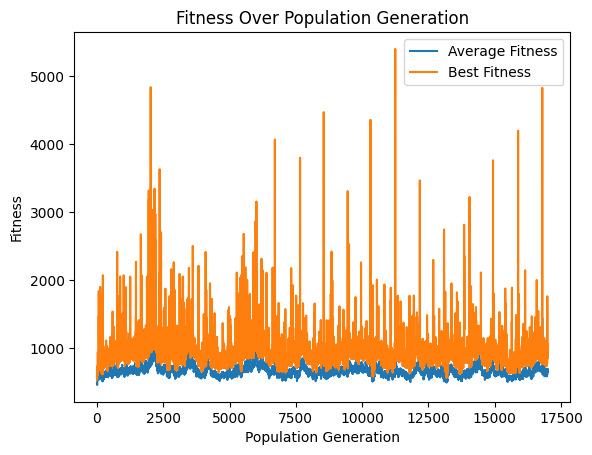

CPU times: user 40.1 s, sys: 220 ms, total: 40.3 s
Wall time: 40.1 s


In [46]:
from ga import main

args = {
    "POPULATION_SIZE": 100,
    "NUMBER_ITERATIONS": 60000,
    "MUTATION_PCT": 0.5,
    "BRAKE_ON_SOLUTION": True,
    "OUTPUT": "ga",
}

%time main(args=args)